## Import libraries

You need Theano to run pymc3. Sometimes while installing PyMC3 in windows with Conda, this might throw a couple or warnings or in some extreme cases, errors. Make sure you have mingw installed.

If installing the latest release, dependencies get installed automatically with conda.

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc3 as pm
import theano.tensor as T

## Example 1: Estimating mean of Poisson distributed data

In [13]:
# generate data
lambda_true = 10
n = 10000
y = np.random.poisson(lambda_true, n)


# Define model and estimate
with pm.Model() as model:
    # Define prior
    lambda_prior = pm.Uniform('lambda_prior', 0, 20)

    # Define the observed level    
    Y_obs = pm.Poisson('Y_obs', mu=lambda_prior, observed=y)
    
    # Sample    
    trace = pm.sample(10000, chains=5, tune=2000)
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (5 chains in 4 jobs)
NUTS: [lambda_prior]
Sampling 5 chains: 100%|████████████████████████████████████████████████████| 60000/60000 [00:34<00:00, 1718.31draws/s]


### Diagnostic plots

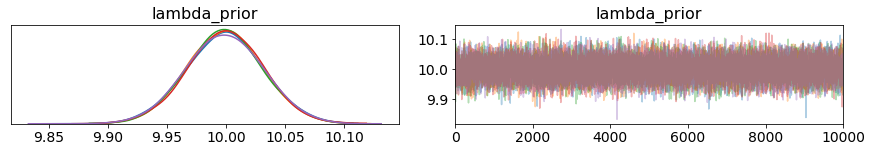

In [14]:
pm.traceplot(trace);

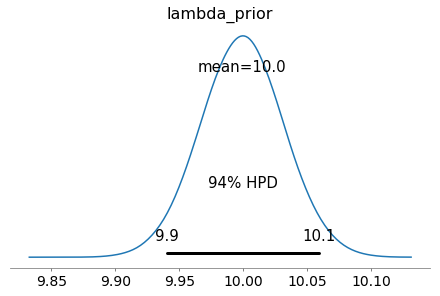

In [15]:
pm.plot_posterior(trace);

In [16]:
burn_in = 5000
n_thin = 2

In [17]:
trace_thinned = trace[burn_in::n_thin]

In [18]:
pm.stats.summary(trace_thinned)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
lambda_prior,9.998725,0.031511,0.000321,9.937031,10.061928,8794.489383,0.999954


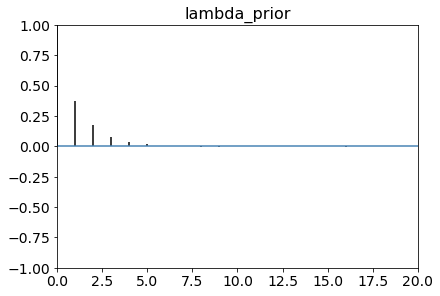

In [19]:
pm.autocorrplot(trace, max_lag=20, combined=True);

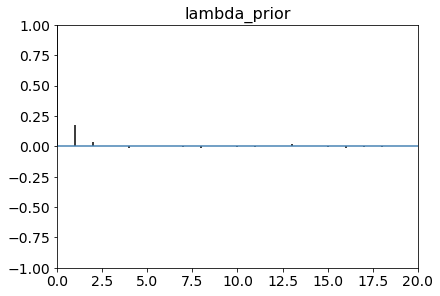

In [20]:
pm.autocorrplot(trace_thinned, max_lag=20, combined=True);

## Example 2: Spatially distributed data

In [24]:
# Generate data as in slide example

phi0 = 0.03
sigma2 = 10
N=4
mu = np.zeros(N)
dist_mat = np.array([[0.        , 0.05018869, 0.1523616 , 0.04786169, 0.2962167 ],
       [0.05018869, 0.        , 0.1043452 , 0.09433808, 0.2523479 ],
       [0.15236161, 0.10434522, 0.        , 0.19848576, 0.1513349 ],
       [0.04786169, 0.09433808, 0.1984858 , 0.        , 0.3439195 ],
       [0.29621667, 0.2523479 , 0.1513349 , 0.34391955, 0.        ]])
dist_mat = dist_mat[:N, :N]
dist_mat += 0.00001*np.eye(N)

# Uncomment the following lines if the dist_mat is not normalized
# minx = np.min(dist_mat)
# maxx = np.max(dist_mat)
# dist_mat = (dist_mat - minx)/(maxx-minx)

omega = np.exp(-phi0*dist_mat)
cov_mat = sigma2*omega
s0 = np.random.multivariate_normal(mu, cov_mat)
# Expected risks for each region
expected = np.array([130, 140, 150, 160, 170])[:N]

In [25]:
# Generate poisson counts
y0 = np.random.poisson(np.exp(s0)*expected)

In [26]:
y0

array([ 7563,  9276, 14146,  9707])

In [27]:
# There might be divergence warnings, try to increase tuning steps or samples.
# If that still doesn't help, try to change prior parameters, like alpha beta or Uniform dist bounds for phi

with pm.Model() as model:
    
    mu = np.zeros(N)
    
    sigma2 = pm.InverseGamma('sigma2', alpha=5, beta=30, shape=1)
    phi = pm.Uniform('phi', 0.00005, 0.05, shape=1)
    
#     Try and experiment with different priors
#     phi = pm.HalfNormal('phi', sigma=1e-5, shape=1)

    omega = T.exp(-phi * dist_mat)

    s = pm.MvNormal('s', mu=mu, cov=sigma2*omega, shape=N)
    
    p = pm.Poisson('y', mu=T.exp(s) * expected, observed=y0)
    
#     If using windows, set cores=1. There are some open issues on multiprocessing in windows in the current distribution of pymc3

    trace = pm.sample(10000, tune=2000, cores=1, target_accept=0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\ProgramData\Anaconda3\envs\theano2\lib\site-packages\theano\tensor\basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
Sequential sampling (2 chains in 1 job)
NUTS: [s, phi, sigma2]
100%|███████████████████████████████████████████████████████████████████████████| 12000/12000 [01:09<00:00, 171.48it/s]


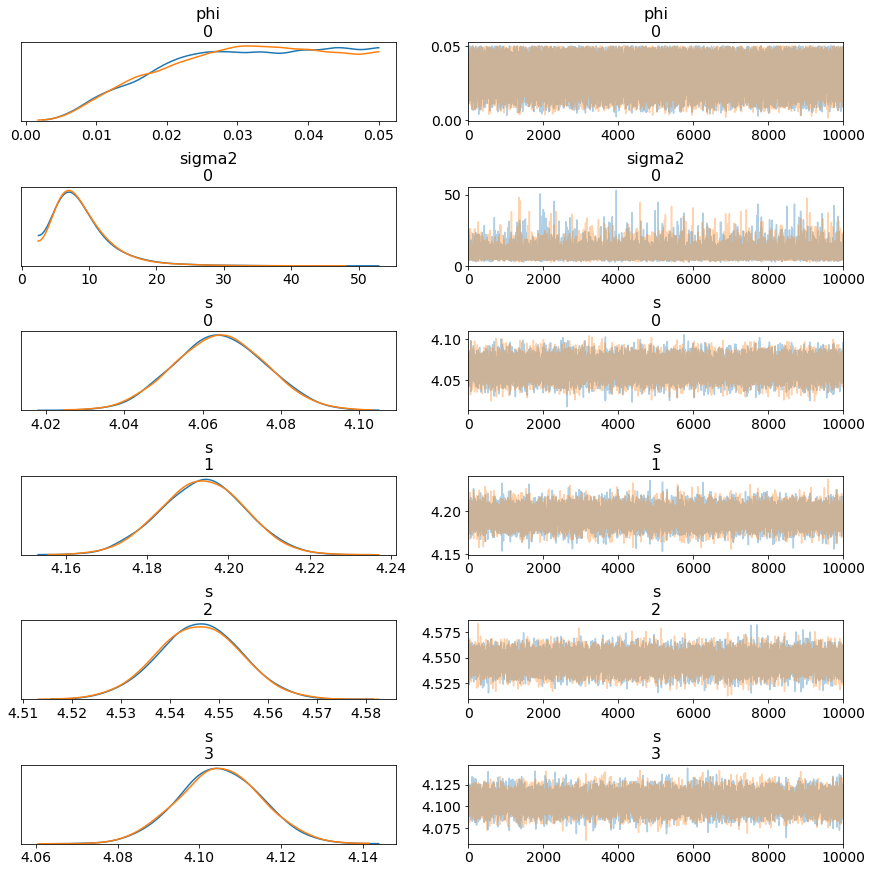

In [28]:
pm.traceplot(trace, var_names=['phi', 'sigma2', 's']);


In [29]:
pm.stats.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
s__0,4.064411,0.011488,0.000068,4.043353,4.087844,26025.269625,0.999952
s__1,4.193674,0.010316,0.000072,4.173220,4.213360,21570.106531,0.999954
s__2,4.546035,0.008474,0.000054,4.528660,4.562111,21872.038097,1.000156
s__3,4.105056,0.010111,0.000058,4.084414,4.124168,26333.383512,0.999954
sigma2__0,9.145147,4.448574,0.034589,3.274712,17.732282,14419.890727,0.999952
phi__0,0.031428,0.011260,0.000080,0.012089,0.050000,17859.391860,0.999977
